## Bubble dissolution _à la_ Venerus JNNFM 2015

* dependencies : [`process_functions.py`](./process_functions.py), [`Dissolution_type.png`](./Dissolution_type.png) (for experimental data), `scipy`, `numpy` and `matplotlib`

### A few things about the code : 

Considering the values of $N_{\rm p}$ and $N_{\rm a}$, I have completely omitted viscous contributions to the stress in Equation (22) of the 2015 JNNFM paper of Venerus. They will be small anyway maybe except very close to bubble dissolution, which will only affect the last experimental data points of the dissolution profiles.

I have first computed, for this value of $N_{\sigma}$, a function that yields the extent $S$ of the yielded region as a function of $R$ and $R_0$. This can be done (badly) by computing this extent $S$ for plenty of values of $R/R_0 = \epsilon$ [numerically solving Equation (20) from the paper] and creating an 'interpolating function' to produce values of $S$ for any $\epsilon$. This is not too problematic since $S$ is not really singular for any $\epsilon$ and tends to a well-defined constant value for $R \to 0$ and to a value proportional to $R$ for $\epsilon \to \infty$.

This allows us to compute the elastic and plastic contributions to the bubble pressure [from Equation (22)] for any given $\epsilon = R/R_0$. Since both terms involve $S$, I have also created interpolating functions to compute them for any $\epsilon$. 

Summing these two contributions and adding the Laplace term give the total extra pressure in the bubble compared to far away from it, $p(R) - p_0$. 

#### Breakdown of the standard parameters as a function of $R$

c:\Users\saint-michel\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
d:\Brice\Python\bubbledissolution_venerus\functions.py:188: RuntimeWarning: invalid value encountered in power
  vfun = lambda R, S_fun : ((1 - (R**3 - 1**3)/S_fun**3)**(+4/3) - 1)**2 \
d:\Brice\Python\bubbledissolution_venerus\functions.py:189: RuntimeWarning: invalid value encountered in power
  + 2*((1 - (R**3 - 1**3)/S_fun**3)**(-2/3) - 1)**2 \


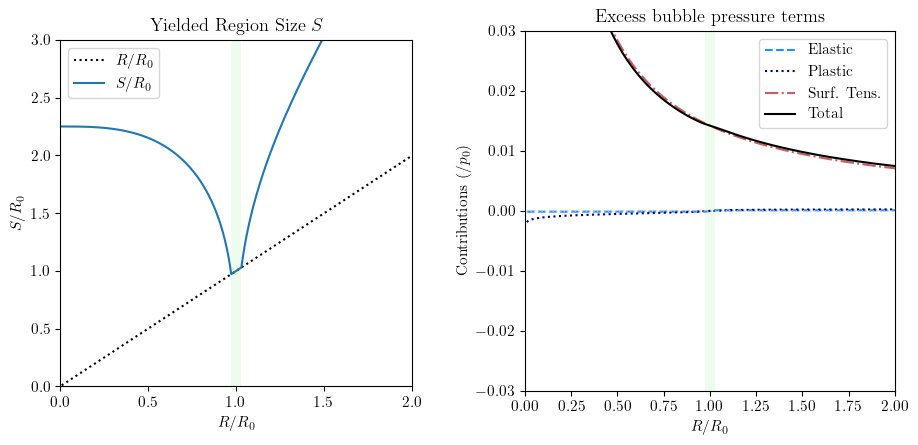

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import functions as fun

#### WE CAN PLAY WITH MATRIX PROPERTIES HERE
bubble = fun.bubble_params(G=100, yieldstress=10, R=100e-6, surftens=.072)
####

S_fun, dS_fun = fun.S_fun(bubble)
P_fun = fun.P_fun(bubble, S_fun)
G_fun = fun.G_fun(bubble, S_fun)
YS_fun = fun.YS_fun(bubble, S_fun)
ST_fun = lambda eps : 2*bubble.surftens/bubble.r0/eps/bubble.p0

r0 = bubble.r0
eps = np.linspace(0.01,2,5000) 
unyielded, = np.where(YS_fun(eps) == 0)
Rmin, Rmax = eps[unyielded[0]], eps[unyielded[-1]]

#######################################################################################################################################################
# Figure generation
# A few MATPLOTLIB parameters first

rc_params = {'text.usetex':True,
              'font.family':'serif',
              'font.size':11}
plt.rcParams.update(rc_params)
fig, ax = plt.subplots(ncols=2)

# Drawing things on figure
ax[0].plot(eps, eps, 'k:', label='$R/R_0$')
ax[0].plot(eps, S_fun(eps), '-', label='$S/R_0$')

ax[1].plot(eps, G_fun(eps)  , '--', color='dodgerblue', linewidth=1.5, label='Elastic')
ax[1].plot(eps, YS_fun(eps) , ':' , color='navy'      , linewidth=1.5, label='Plastic')
ax[1].plot(eps, ST_fun(eps) , '-.', color='indianred' , linewidth=1.5, label='Surf. Tens.')
ax[1].plot(eps, P_fun(eps)-1, '-' , color='black'     , linewidth=1.5, label='Total')
ax[1].plot(eps, 0*eps       , ':' , color='lightgray' , linewidth=1)

rect0 = patches.Rectangle(xy=(Rmin, -1), width=(Rmax-Rmin), height=4, \
                         facecolor='lightgreen', edgecolor='none', alpha=0.15)                         
rect1 = patches.Rectangle(xy=(Rmin, -1), width=(Rmax-Rmin), height=2, \
                         facecolor='lightgreen', edgecolor='none', alpha=0.15)

ax[0].add_patch(rect0)
ax[1].add_patch(rect1)

# Figure Formatting
fig.set_size_inches(w=10, h=4.5)

ax[0].legend()
ax[1].set_position([0.09,0.10,0.37,0.8])
ax[0].set_title('Yielded Region Size $S$')
ax[0].set_xlabel('$R/R_0$')
ax[0].set_ylabel('$S/R_0$')
ax[0].set_xlim([0,2])
ax[0].set_ylim([0,3])

ax[1].set_position([0.59,0.10,0.37,0.8])
ax[1].set_ylim([-0.03, 0.03])
ax[1].set_title('Excess bubble pressure terms')
ax[1].set_ylabel('Contributions ($/p_0$)')
ax[1].set_xlabel('$R/R_0$')
ax[1].set_xlim([0,2])
ax[1].legend()

plt.show()

We do recover here the $S/R_0 \to 2.25$ of Fig.3 (right) of Venerus JNNFM 2015 (with the x axis flipped), which is quite reassuring. Considering values of $N_\sigma$ above $0.1$ seems a bit odd to me, since most yield-stress fluids are more _fragile_ than Carbopol. Reasonable limits for such a value should be between $0$ and $0.2$. The range of radii for which the matrix is unyielded is very small, and only spans from $R/R_0 =  0.97$ to $R/R_0 = 1.03$.

In the figure on the right, we quite clearly see that the elastic and plastic contributions to the pressure inside the bubble are really small compared to the Laplace pressure. The impact of the yield-stress matrix on the dissolution process should then be minimal.

### Numerical solving of the $R(t)$ ODE

The ODE governing $R(t)$ can be a bit stiff, but the one expressing $\epsilon(x)$ ([see README.md](./README.md)) is easily be solved using a RK45 scheme from `scipy`, and also supports very well the use of _events_, i.e. they can stop the integration when $R(t)$ reaches $0$. 

Let us now compare three dissolution profiles, one (`bubble1`) with no elastic modulus (in which case the yield stress does not matter), one (`bubble2`) with a small elastic modulus and yield stress corresponding to the Carbopols I have been using in my experiments, and one stiffer yield-stress fluid (`bubble3`)

C:\Users\saint-michel\AppData\Local\Temp\ipykernel_5520\3544055951.py:16: RuntimeWarning: divide by zero encountered in divide
  ST_fun = lambda eps : 2*bubble.surftens/bubble.r0/eps/bubble.p0 # This one is the same for all


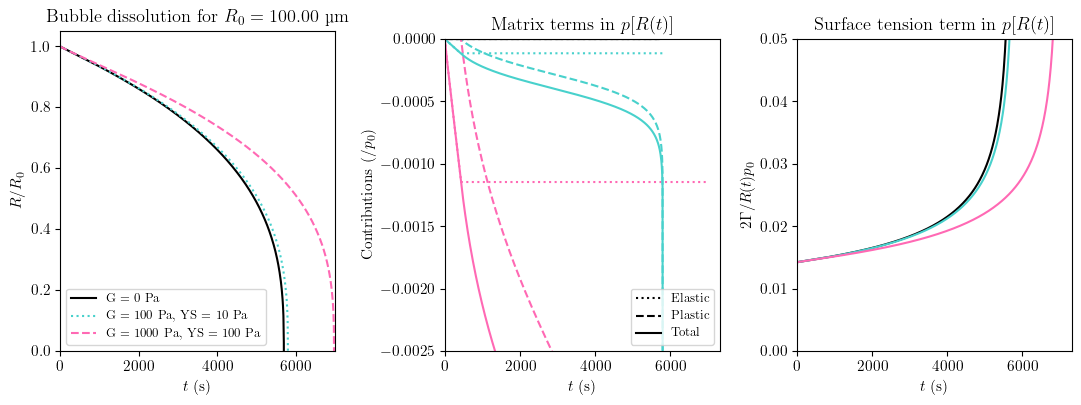

In [4]:
R0 = 100e-6
bubble1 = fun.bubble_params(R=R0, G=0, yieldstress=30, surftens=0.072)
bubble2 = fun.bubble_params(R=R0, G=100, yieldstress=10, surftens= 0.072)
bubble3 = fun.bubble_params(R=R0, G=1000, yieldstress=100, surftens=0.072)

bubble1 = fun.model_dissolution_Venerus(bubble1)
bubble2 = fun.model_dissolution_Venerus(bubble2)
bubble3 = fun.model_dissolution_Venerus(bubble3)

S2_fun, _ = fun.S_fun(bubble2)
S3_fun, _ = fun.S_fun(bubble3)             # NOTE : S2_fun and S3_fun will here be the same since the radio YS/G is the same for both, but it is not necessarily the case
G2_fun = fun.G_fun(bubble2, S2_fun)
G3_fun = fun.G_fun(bubble3, S3_fun)
YS2_fun = fun.YS_fun(bubble2, S2_fun)
YS3_fun = fun.YS_fun(bubble3, S3_fun)
ST_fun = lambda eps : 2*bubble.surftens/bubble.r0/eps/bubble.p0 # This one is the same for all

#######################################################################################################################################################
# Figure generation

fig, ax = plt.subplots(ncols=3)
ax[0].plot(bubble1.time_ODEfit, (bubble1.r_ODEfit/R0), '-'  , color='black'          , label= f'G = 0 Pa')
ax[0].plot(bubble2.time_ODEfit, (bubble2.r_ODEfit/R0), ':'  , color='mediumturquoise', label= f'G = {bubble2.G:.0f} Pa, YS = {bubble2.yieldstress:.0f} Pa')
ax[0].plot(bubble3.time_ODEfit, (bubble3.r_ODEfit/R0), '--' , color='hotpink'        , label= f'G = {bubble3.G:.0f} Pa, YS = {bubble3.yieldstress:.0f} Pa')

ax[1].plot(bubble1.time_ODEfit, 0*bubble1.r_ODEfit/R0       , ':', color='black'          , label='Elastic')
ax[1].plot(bubble2.time_ODEfit, G2_fun(bubble2.r_ODEfit/R0) , ':', color='mediumturquoise')
ax[1].plot(bubble3.time_ODEfit, G3_fun(bubble3.r_ODEfit/R0) , ':', color='hotpink')
ax[1].plot(bubble1.time_ODEfit, 0*bubble1.r_ODEfit/R0       , '--', color='black'          , label='Plastic')
ax[1].plot(bubble2.time_ODEfit, YS2_fun(bubble2.r_ODEfit/R0), '--', color='mediumturquoise')
ax[1].plot(bubble3.time_ODEfit, YS3_fun(bubble3.r_ODEfit/R0), '--', color='hotpink')
ax[1].plot(bubble1.time_ODEfit, 0*bubble1.r_ODEfit/R0                                     , '-', color='black' , label='Total')
ax[1].plot(bubble2.time_ODEfit, YS2_fun(bubble2.r_ODEfit/R0) + G2_fun(bubble2.r_ODEfit/R0), '-', color='mediumturquoise')
ax[1].plot(bubble3.time_ODEfit, YS3_fun(bubble3.r_ODEfit/R0) + G3_fun(bubble3.r_ODEfit/R0), '-', color='hotpink')

ax[2].plot(bubble1.time_ODEfit, ST_fun(bubble1.r_ODEfit/R0), '-', color='black'          )
ax[2].plot(bubble2.time_ODEfit, ST_fun(bubble2.r_ODEfit/R0), '-', color='mediumturquoise')
ax[2].plot(bubble3.time_ODEfit, ST_fun(bubble3.r_ODEfit/R0), '-', color='hotpink')

# Figure formatting
ax[0].set_position([0.05,0.12,0.25,0.80])
ax[0].set_title(f'Bubble dissolution for $R_0 = {1e6*R0:.2f} $~µm ')
ax[0].set_xlabel(f'$t$ (s)')
ax[0].set_ylabel(f'$R/R_0$')
ax[0].set_ylim([0,1.05])
ax[0].set_xlim(left=0, right=7000)
ax[0].legend(fontsize=9)

ax[1].set_position([0.40,0.12,0.25,0.78])
ax[1].set_title(f'Matrix terms in $p[R(t)]$')
ax[1].set_xlabel(f'$t$ (s)')
ax[1].set_ylabel(f'Contributions ($/p_0$)')
# ax[1].set_yticks([-0.005,-0.004,-0.003, -0.002, -0.001,-0.000])
ax[1].set_ylim([-0.0025,0])
ax[1].set_xlim(left=0)
ax[1].legend(fontsize=9)

ax[2].set_position([0.72,0.12,0.25,0.78])
ax[2].set_title(f'Surface tension term in $p[R(t)]$')
ax[2].set_xlabel(f'$t$ (s)')
ax[2].set_ylabel(f'$2 \Gamma /R(t) p_0$')
ax[2].set_xlim(left=0)
ax[2].set_ylim([0,0.05])

fig.set_size_inches(w=11, h=4)

plt.show()

We conclude from these figures that for a weak Carbopol, we only do see a marginal difference in dissolution profiles compared to the reference case of a Newtonian fluid. If we saw such a small deviation in experiments, we could interpret it : 

* as a slight change in surface tension in the Carbopol compared to water: here, $\Gamma = 0.0705$ N/m instead of $0.072$ N/m makes the teal and the black curve coincide. These values are well within the uncertainty margins for the surface tension of Carbopol in the literature (and my experiments)
* as a _tiny_ oversaturation ($f = 1.0004$ instad of $f = 1$ to  make the teal and the black curve coincide) of the water, which could very well be possible, e.g. if the weather has been nice in the last five days and becomes overcast or rainy : this change of $f$ would represent a change in $p_0$ of less than 1 hPa, also well within what the weather can do, which is in the range $[0.982\,;\,1.015]$

### Comparison with experiments

The experimental dissolution profiles I obtained are shown in the figure below (square symbols), with the Carbopol properties used in the previous section and $R_0 = 125$ µm, which should not change the dimensionless numbers we have been using.

<img src="./Dissolution_type.png" width="400" />

Here, the dissolution profiles have been fitted using a different algorithm, based on the explicit solution of [Michelin _et al._](https://doi.org/10.1103/PhysRevFluids.3.043601), which assume a low-viscosity Newtonian surrounding matrix. We have just shown above that in the framework of Venerus JNNFM 2015, bubble dissolution _should not be affected_ by the mechanical properties of my Carbopols. 

The best fit to the experimental data suggests a saturation factor around $0.99$, which is understandable considering weather variability. I have never managed to obtain reliably $f = 1.000$, even though I drew my DI water around 1 month before I prepare my Carbopol and despite waiting for more than a week before starting experiments in a temperature-controlled cell of size $5 \times 5 \times 5~\text{cm}^3$. The values I obtain usually fall into the range $[0.975\,;\,0.998]$, but differs from one bubble to the next, irrespective of whether I stir the fluid between experiments, and irrespective of the bubble injection depth.

Even more surprising is the value of the _effective_ surface tension, which is quite low, and seems to be decreasing with increasing yield stress. Here, the value extracted from the fit lies around $[0.02\,;\,0.04]$, with again poor repeatability for a range of yield stresses $\sigma_Y$ under 10 Pa.